In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import funcy

import statsmodels.api as sm

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
import random

In [2]:
telecom_data = pd.read_csv("telecom_churn_data.csv")
print(telecom_data.shape)
telecom_data.head()

(99999, 226)


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [3]:
## Filter out High value customers
telecom_data = telecom_data.dropna(subset = ['total_rech_amt_6', 'total_rech_amt_7'])
telecom_data['av_rech_amt_data_6_7'] = (telecom_data['av_rech_amt_data_6'] + telecom_data['av_rech_amt_data_7']) / 2
telecom_data['total_rech_amt_6_7'] = (telecom_data['total_rech_amt_6'] + telecom_data['total_rech_amt_7']) / 2
high_value_cutoff = telecom_data['total_rech_amt_6_7'].quantile(0.7)
telecom_data = telecom_data[telecom_data['total_rech_amt_6_7'] >= high_value_cutoff]

## Applying churn as given in the assignment
def churn_test(row):
    return  (1 if (row["total_ic_mou_9"] == 0 and
                   row["total_og_mou_9"] == 0 and
                   row["vol_2g_mb_9"] == 0 and
                   row["vol_3g_mb_9"] == 0) else 0)

telecom_data["churn"] = telecom_data.apply(lambda row: churn_test(row), axis=1)
prior_prob_churn = telecom_data[telecom_data["churn"] == 1].shape[0] / telecom_data.shape[0]
print("Prior Probabilities of churn", prior_prob_churn)

Prior Probabilities of churn 0.08640165272733331


In [4]:
## Drop all 9th month columns
print(len(telecom_data.columns))
telecom_data.drop(list(filter(lambda x: x.endswith("_9"), telecom_data.columns)), inplace=True, axis=1)
print(len(telecom_data.columns))

229
175


In [5]:
## Date columns
date_columns = list(filter(lambda x: "date" in x ,telecom_data.columns))
for dc in date_columns:
    telecom_data["MODIFIED_day_of_month_" + dc] = pd.to_datetime(telecom_data[dc]).dt.day
    telecom_data = telecom_data.drop([dc], axis=1)

In [6]:
churned_data = telecom_data[telecom_data["churn"] == 1]
# Find all features to explore NA not more than 50% zeros not more than 50
columns_churned = list(churned_data.columns)
columns_churned = list(filter(lambda x: (churned_data[x].isnull().sum(axis = 0) / churned_data.shape[0]) < 0.5, columns_churned))
columns_churned = list(filter(lambda x: ((churned_data.shape[0] - churned_data[x].nonzero()[0].shape[0] )/ churned_data.shape[0] < 0.5), columns_churned))
columns_churned = list(filter(lambda x: (churned_data[x].var() > 0.0), columns_churned))
print("Cols to observe {}".format(len(columns_churned)))

Cols to observe 73


In [7]:
non_churned_data = telecom_data[telecom_data["churn"] == 0]
# Find all features to explore NA not more than 50% zeros not more than 50
columns_non_churned = list(non_churned_data.columns)
columns_non_churned = list(filter(lambda x: (non_churned_data[x].isnull().sum(axis = 0) / non_churned_data.shape[0]) < 0.5, columns_non_churned))
columns_non_churned = list(filter(lambda x: ((non_churned_data.shape[0] - non_churned_data[x].nonzero()[0].shape[0]) / non_churned_data.shape[0] < 0.5), columns_non_churned))
columns_non_churned = list(filter(lambda x: (non_churned_data[x].var() > 0.0), columns_non_churned))
print("Cols to observe {}".format(len(columns_non_churned)))

Cols to observe 78


In [8]:
columns_to_explore = set(columns_non_churned).union(set(columns_churned))
features_to_explore = set(map(lambda x: x.replace("_6", "")
                                     .replace("_7", "")
                                     .replace("_8", ""), columns_to_explore))
print("# cols to explore {}\n Features to explore: {}".format(len(columns_to_explore), features_to_explore))
telecom_data_mod = telecom_data.dropna(subset=list(telecom_data))
print("Churned Count: Before : {}   After:  {}".format(telecom_data[telecom_data["churn"] == 1].shape[0], 
                                                       telecom_data_mod[telecom_data_mod["churn"] == 1].shape[0]))
print("NON Churned Count: Before : {}   After:  {}".format(telecom_data[telecom_data["churn"] == 0].shape[0],
                                                           telecom_data_mod[telecom_data_mod["churn"] == 0].shape[0]))


## Find percentage of na values
na_zero_cols = pd.DataFrame([{
               "column": c,
               "prec_na": telecom_data[c].isnull().sum(axis=0)/telecom_data.shape[0],
               "prec_0": (telecom_data.shape[0] - non_churned_data[c].nonzero()[0].shape[0]) / telecom_data.shape[0]} for c in columns_to_explore])

na_zero_cols = na_zero_cols.sort_values(['prec_0'], ascending=[False])
na_zero_cols.head()

telecom_data = telecom_data.fillna(0)


# cols to explore 80
 Features to explore: {'loc_og_t2f_mou', 'std_og_mou', 'std_ic_t2m_mou', 'total_og_mou', 'offnet_mou', 'arpu', 'loc_og_t2m_mou', 'total_rech_num', 'total_rech_amt', 'aon', 'loc_ic_t2f_mou', 'max_rech_amt', 'loc_ic_t2m_mou', 'std_ic_mou', 'last_day_rch_amt', 'loc_ic_mou', 'roam_ic_mou', 'roam_og_mou', 'loc_og_t2t_mou', 'std_ic_t2t_mou', 'total_ic_mou', 'std_og_t2t_mou', 'onnet_mou', 'spl_og_mou', 'loc_og_mou', 'mobile_number', 'loc_ic_t2t_mou', 'std_og_t2m_mou', 'MODIFIED_day_of_month_date_of_last_rech'}
Churned Count: Before : 2593   After:  172
NON Churned Count: Before : 27418   After:  7360


In [9]:
def analyze_feature(feature_start):
    plt.rcParams["figure.figsize"] = [20, 10]
    fig = plt.figure()
    print("Churn Stats:")
    cols = {c: feature_start + "_" + str(c) for c in [6,7,8]}
    print(cols)
    frame_data = []
    [frame_data.append({
        "mean_6": telecom_data[telecom_data["churn"] == churn][cols[6]].mean(),
        "mean_7": telecom_data[telecom_data["churn"] == churn][cols[7]].mean(),
        "mean_8": telecom_data[telecom_data["churn"] == churn][cols[8]].mean(),
        "var_6": telecom_data[telecom_data["churn"] == churn][cols[6]].var(),
        "var_7": telecom_data[telecom_data["churn"] == churn][cols[7]].var(),
        "var_8": telecom_data[telecom_data["churn"] == churn][cols[8]].var()
    }) for churn in [1, 0]]
    axes = fig.subplots(nrows=1, ncols=3)
    sns.boxplot(data=telecom_data, y=feature_start + "_6", x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[0])
    sns.boxplot(data=telecom_data, y=feature_start + "_7",  x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[1])
    sns.boxplot(data=telecom_data, y=feature_start + "_8",  x="churn",
                hue="churn", linewidth=2.5, showfliers=False, ax=axes[2])
    return pd.DataFrame(frame_data, index={"Churned","Non Churned"})

In [10]:
FEATURES = []
features_explored = set()

Churn Stats:
{6: 'loc_ic_t2t_mou_6', 7: 'loc_ic_t2t_mou_7', 8: 'loc_ic_t2t_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,48.831022,39.088299,14.217540,18476.123749,18266.501361,2587.437769
Churned,70.632761,73.264206,70.828225,25761.506108,28814.425330,26014.528303


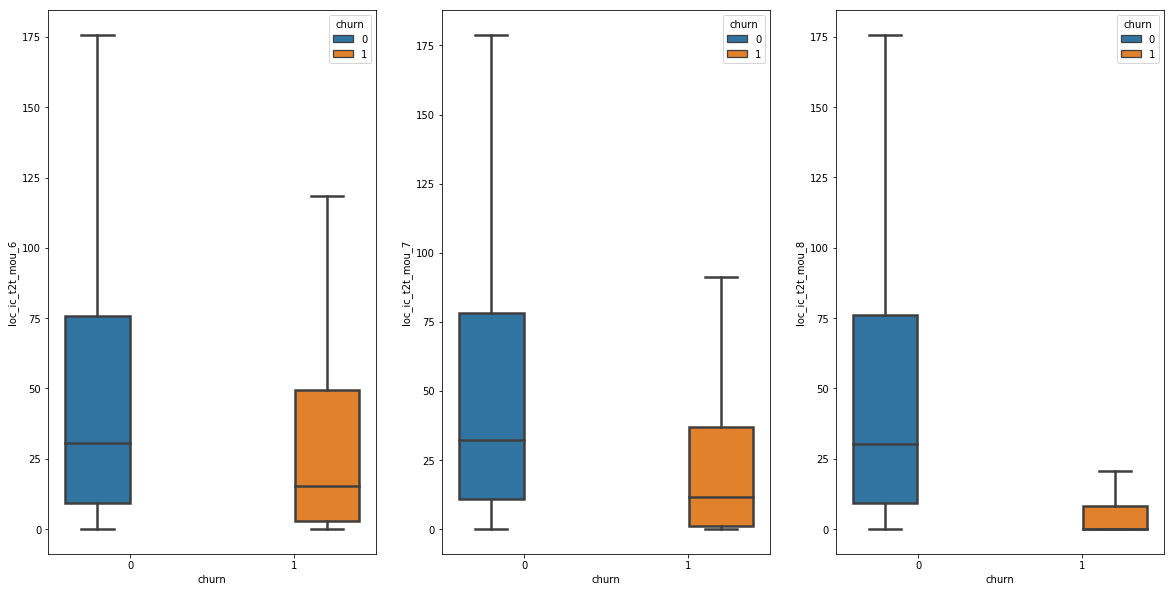

In [11]:
feature = "loc_ic_t2t_mou"
features_explored.update([feature])
features_to_explore.remove(feature)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'total_rech_num_6', 7: 'total_rech_num_7', 8: 'total_rech_num_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,14.364057,11.612032,5.541843,134.556455,107.962077,54.493715
Churned,11.909220,11.941972,10.668247,86.451656,90.776331,90.917838


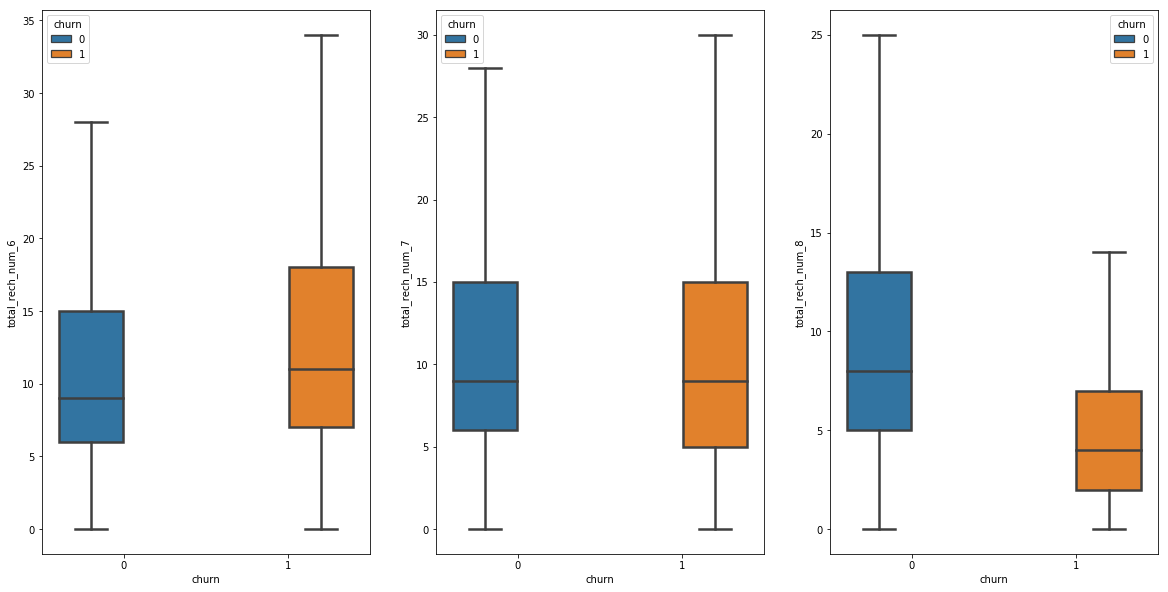

In [12]:
## Total recharge num steady for non churn, sudden drop in action month for churn
feature = "total_rech_num"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'onnet_mou_6', 7: 'onnet_mou_7', 8: 'onnet_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,407.854223,315.527285,120.434821,358245.188301,277356.615507,113451.306141
Churned,285.459341,303.285495,281.518290,197231.198802,227830.576378,225298.720509


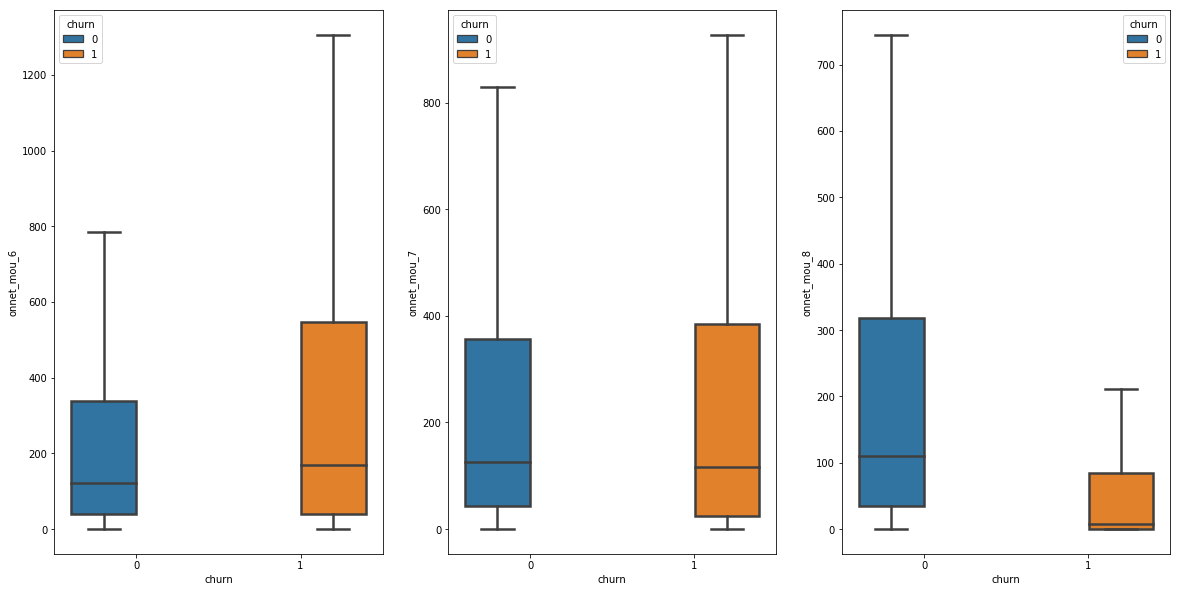

In [13]:
# Sharp decline in action month for onnet_mou or any kind of calls
feature = "onnet_mou"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'total_rech_amt_6', 7: 'total_rech_amt_7', 8: 'total_rech_amt_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,808.441188,637.946008,258.846895,417289.169476,410876.460047,197795.40209
Churned,686.861113,701.449705,647.192501,277654.499366,306698.850828,364713.35405


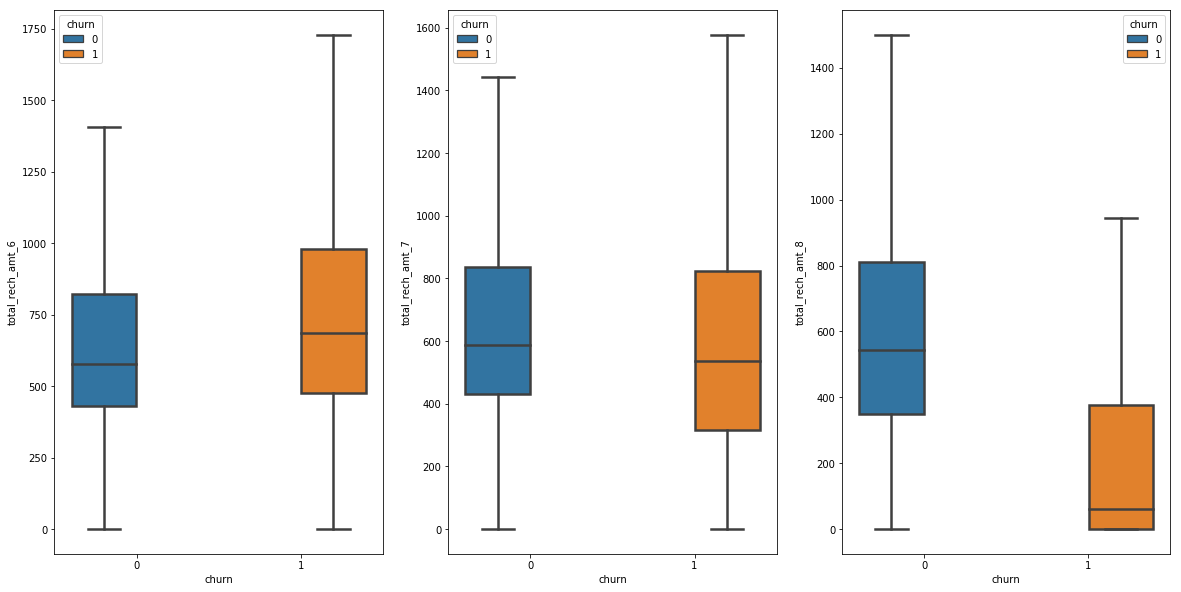

In [14]:
# feature = random.choice(list(features_to_explore))
# analyze_feature(feature)

## Sharp Decline in Total recharge amount
feature = "total_rech_amt"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'loc_ic_t2f_mou_6', 7: 'loc_ic_t2f_mou_7', 8: 'loc_ic_t2f_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,8.015943,7.359414,2.748793,986.498879,1230.625170,303.655600
Churned,16.312462,17.375423,15.837388,2199.525049,2554.631103,2048.137206


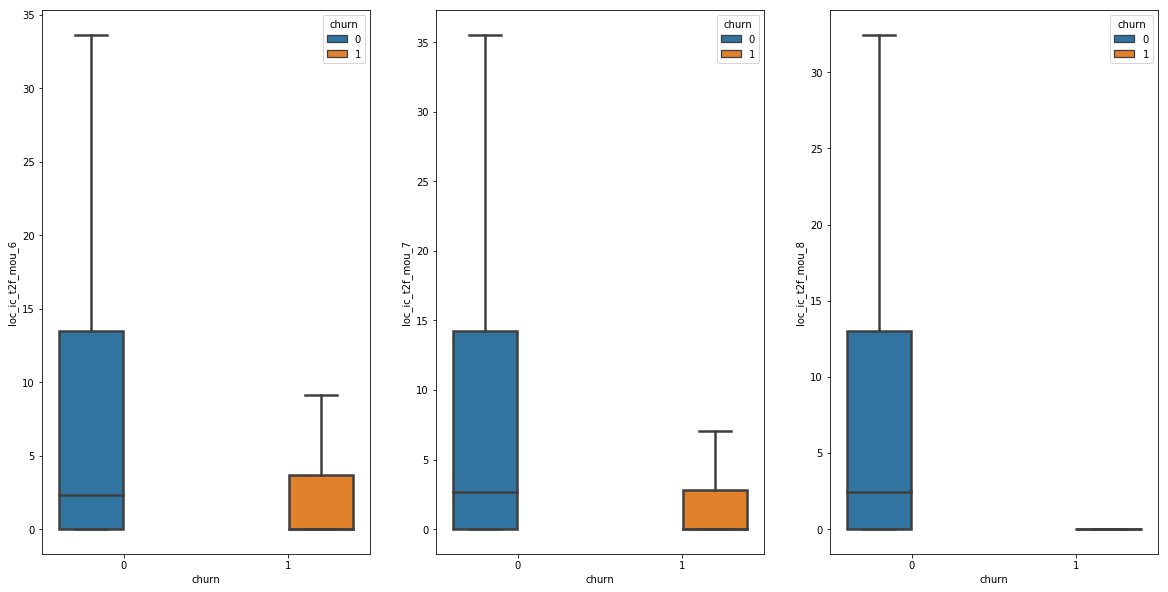

In [15]:
# Churn customers were hardly using the local incoming calls from fixed lines
# feature = random.choice(list(features_to_explore))
# analyze_feature(feature)


feature = "loc_ic_t2f_mou"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'std_og_t2m_mou_6', 7: 'std_og_t2m_mou_7', 8: 'std_og_t2m_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,346.119144,274.692503,83.806005,357965.289508,287592.468051,66978.764657
Churned,189.571819,207.616430,188.625356,151183.863439,182354.494023,182827.720476


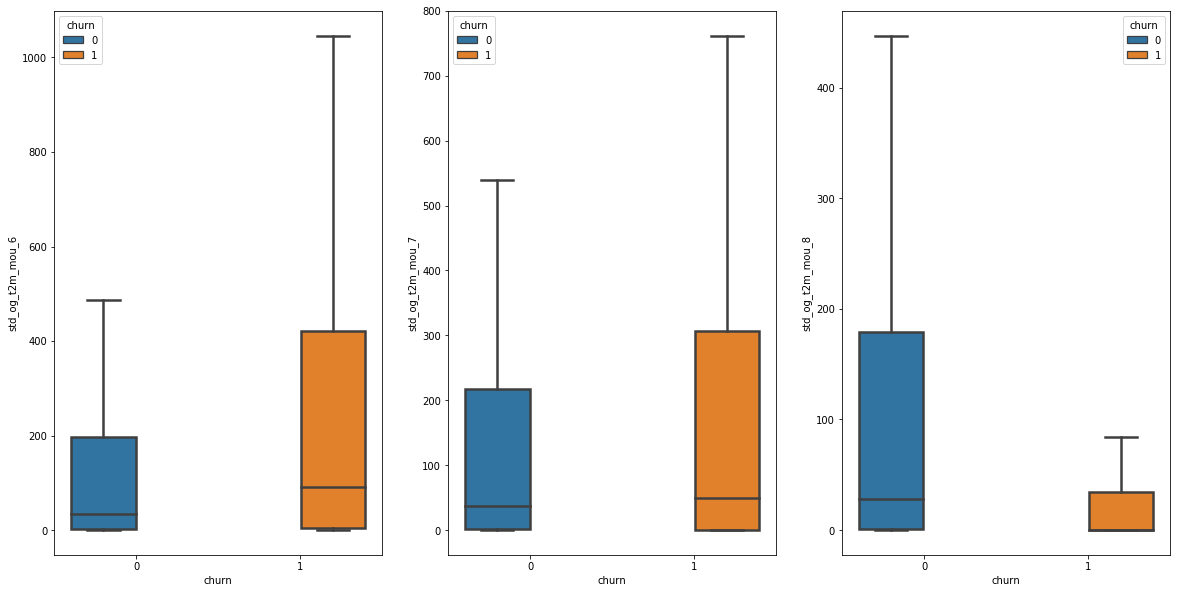

In [16]:
# Sharp decline for STD outgoing for churned

# feature = random.choice(list(features_to_explore))
# analyze_feature(feature)


feature = "std_og_t2m_mou"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)


Churn Stats:
{6: 'loc_ic_mou_6', 7: 'loc_ic_mou_7', 8: 'loc_ic_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,169.635492,135.208199,48.692603,88912.984749,64797.420591,14785.833194
Churned,250.998214,258.277819,251.833266,98123.565442,101497.901541,98228.723002


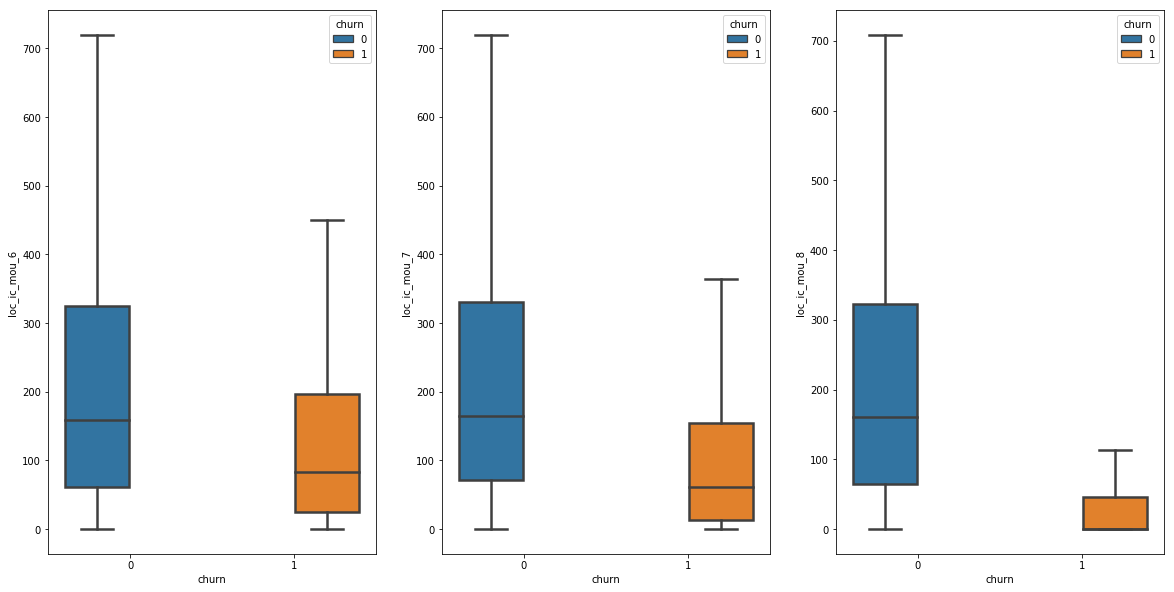

In [17]:
# loc_ic_mou Steady decline in mins of usage for incoming calls

feature = "loc_ic_mou"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)



Churn Stats:
{6: 'loc_og_t2t_mou_6', 7: 'loc_og_t2t_mou_7', 8: 'loc_og_t2t_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,65.741990,46.942102,16.727817,43623.176363,21061.617752,4811.75621
Churned,97.417513,100.343717,93.799079,57192.255152,65155.279849,59336.86887


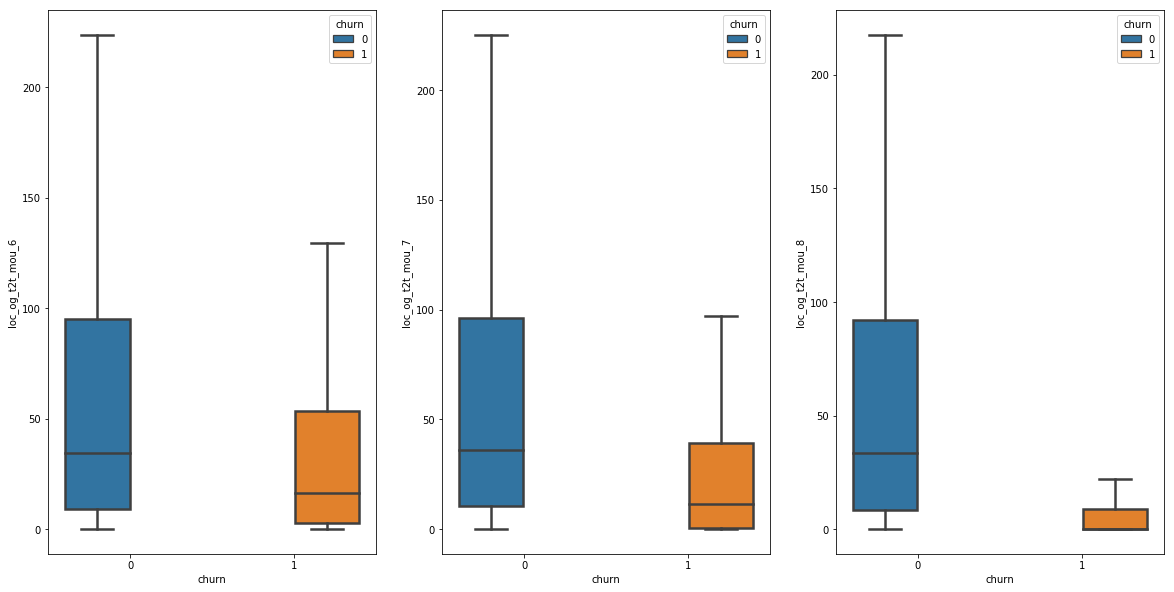

In [18]:
# Sharp decline in local outgoing calls
# feature = random.choice(list(features_to_explore))
# analyze_feature(feature)


feature = "loc_og_t2t_mou"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'std_ic_t2m_mou_6', 7: 'std_ic_t2m_mou_7', 8: 'std_ic_t2m_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,35.271489,28.217447,10.357466,11771.084497,12655.077878,2913.429841
Churned,31.707203,33.974575,32.333533,10070.632868,11054.550212,11821.648003


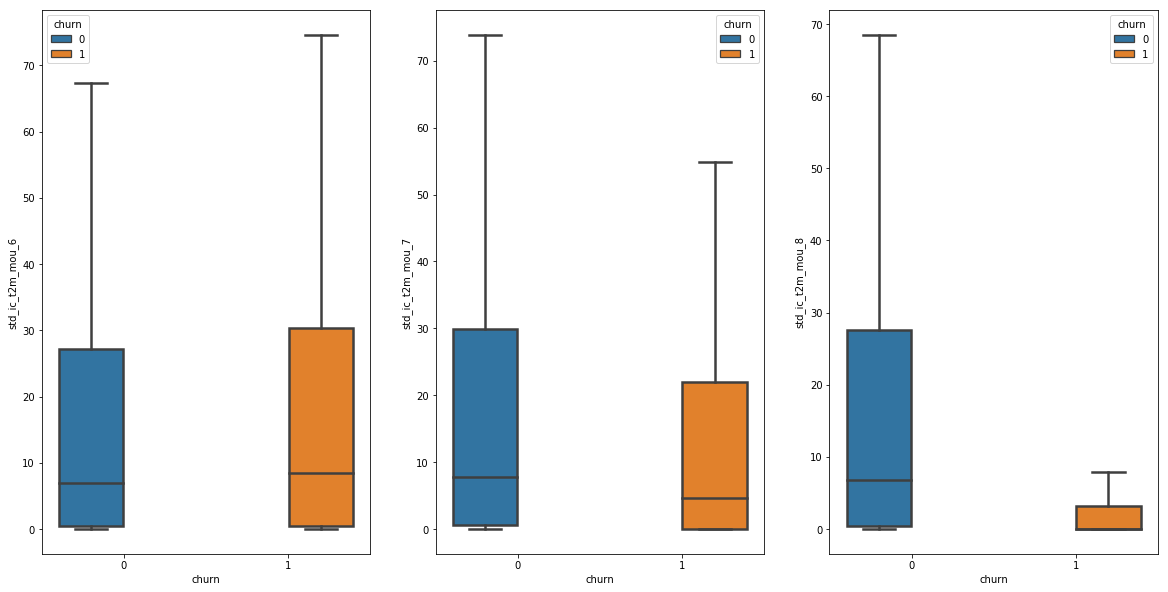

In [19]:
feature = "std_ic_t2m_mou"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'std_ic_mou_6', 7: 'std_ic_mou_7', 8: 'std_ic_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,59.222295,46.642283,15.772422,25218.416185,22260.218776,4048.992165
Churned,50.357017,54.003918,51.235017,19217.536390,22250.094138,21259.077506


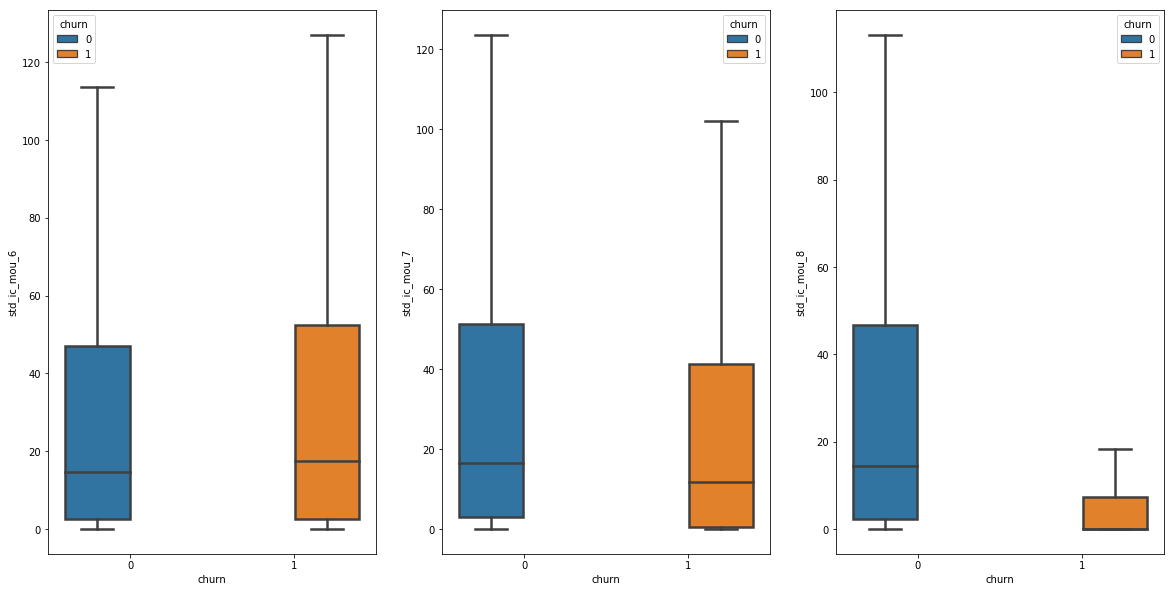

In [20]:
feature = "std_ic_mou"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'loc_og_mou_6', 7: 'loc_og_mou_7', 8: 'loc_og_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,188.778380,143.789395,52.121924,106102.437006,70056.562763,20225.816493
Churned,291.854348,297.377782,281.010269,147095.622184,145951.543571,140618.505382


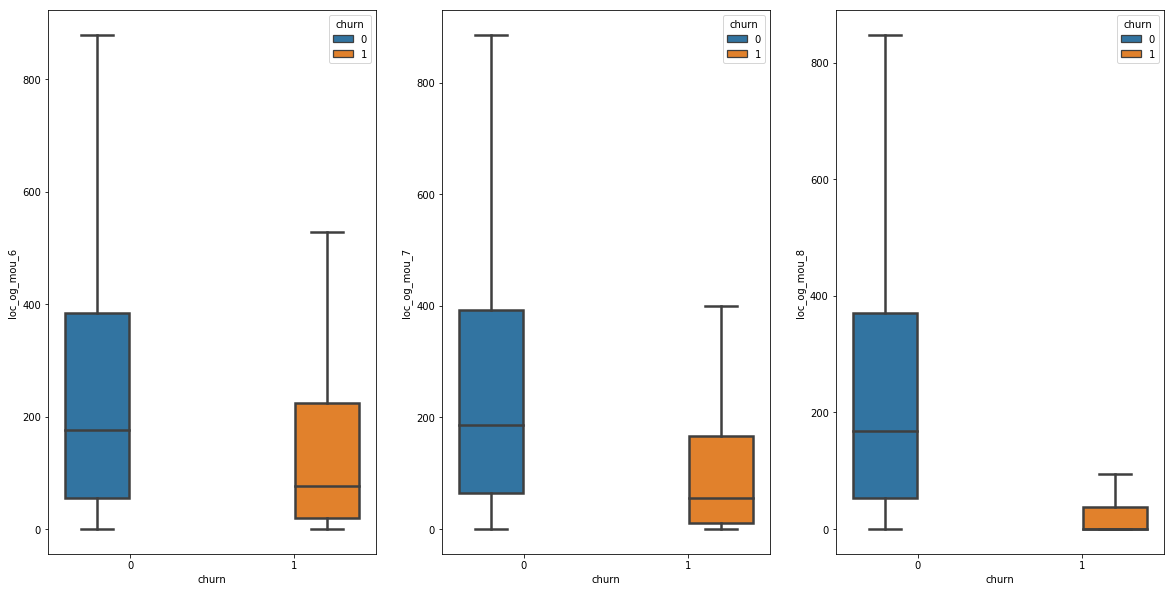

In [21]:
feature = "loc_og_mou"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'spl_og_mou_6', 7: 'spl_og_mou_7', 8: 'spl_og_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,7.067289,7.579487,2.842927,491.679785,515.666601,130.278963
Churned,5.807517,7.410923,7.267482,332.929937,533.592307,559.668590


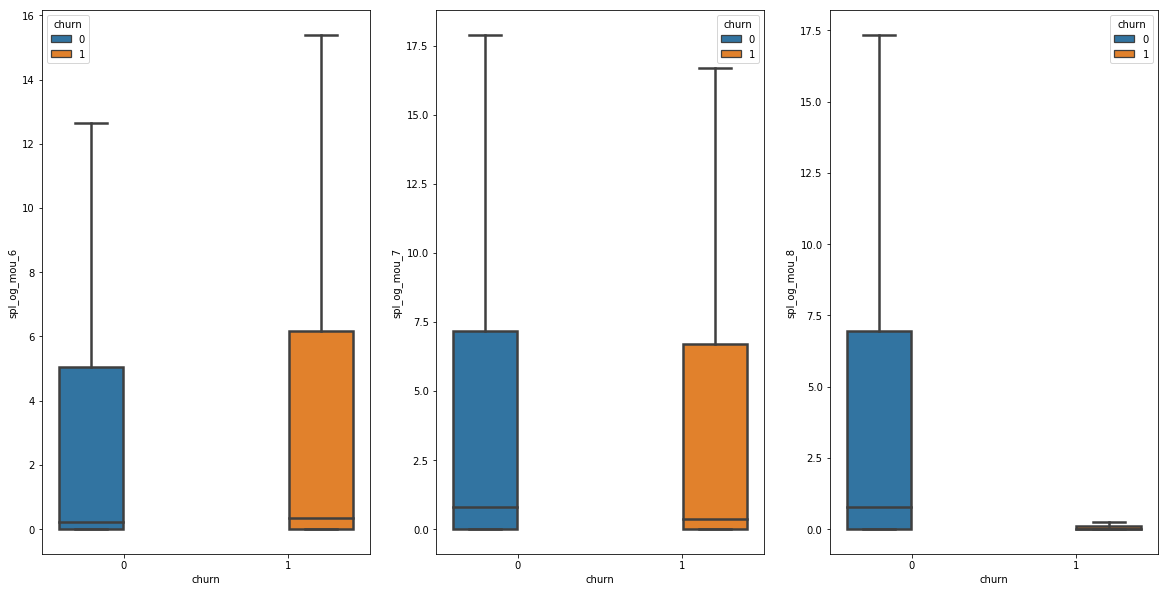

In [22]:
feature = "spl_og_mou"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'loc_og_t2f_mou_6', 7: 'loc_og_t2f_mou_7', 8: 'loc_og_t2f_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,3.647825,3.110756,1.364701,944.434311,659.096089,57.914307
Churned,7.294400,7.474284,6.979437,471.876436,494.558965,439.317883


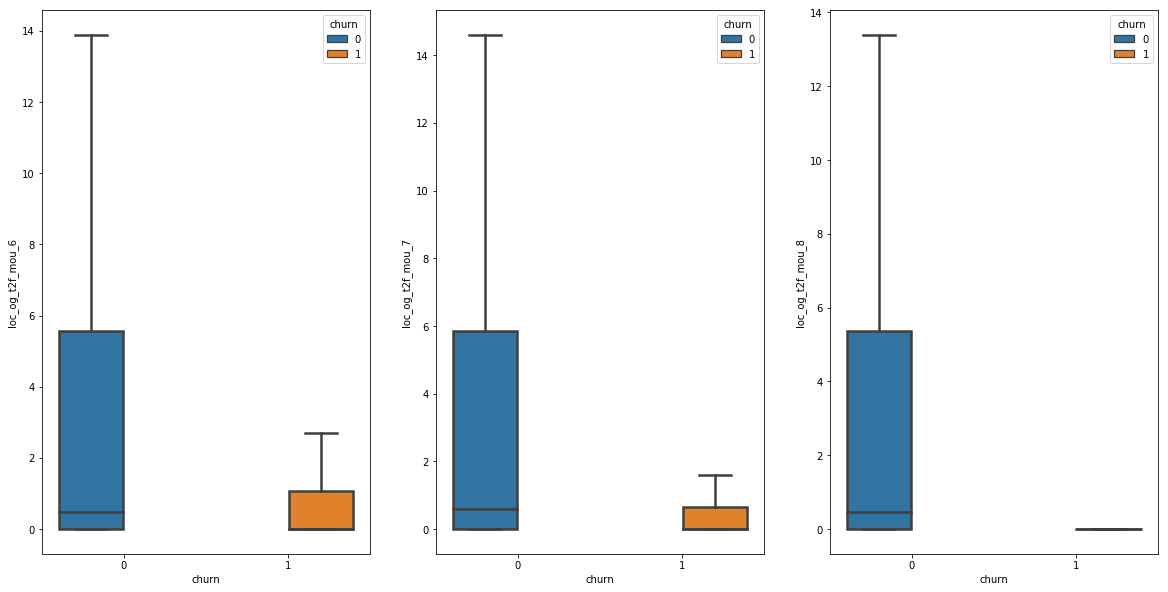

In [23]:
feature = "loc_og_t2f_mou"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'offnet_mou_6', 7: 'offnet_mou_7', 8: 'offnet_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,511.582877,410.068754,149.464732,403140.328872,333277.41059,98911.193077
Churned,409.076666,425.234742,396.353268,203377.150361,227565.89390,234941.379309


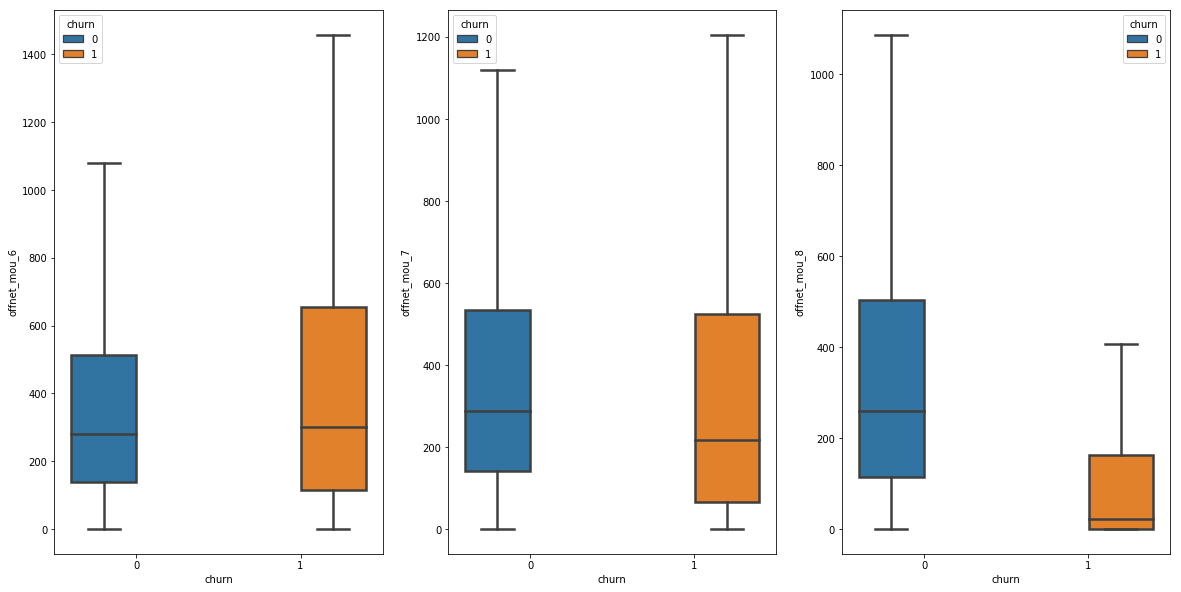

In [24]:
feature = "offnet_mou"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'std_og_t2t_mou_6', 7: 'std_og_t2t_mou_7', 8: 'std_og_t2t_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,319.592661,247.458893,84.610802,318707.390637,250674.283567,89838.298436
Churned,177.473829,195.377598,180.479633,151868.370154,176687.747220,174741.337457


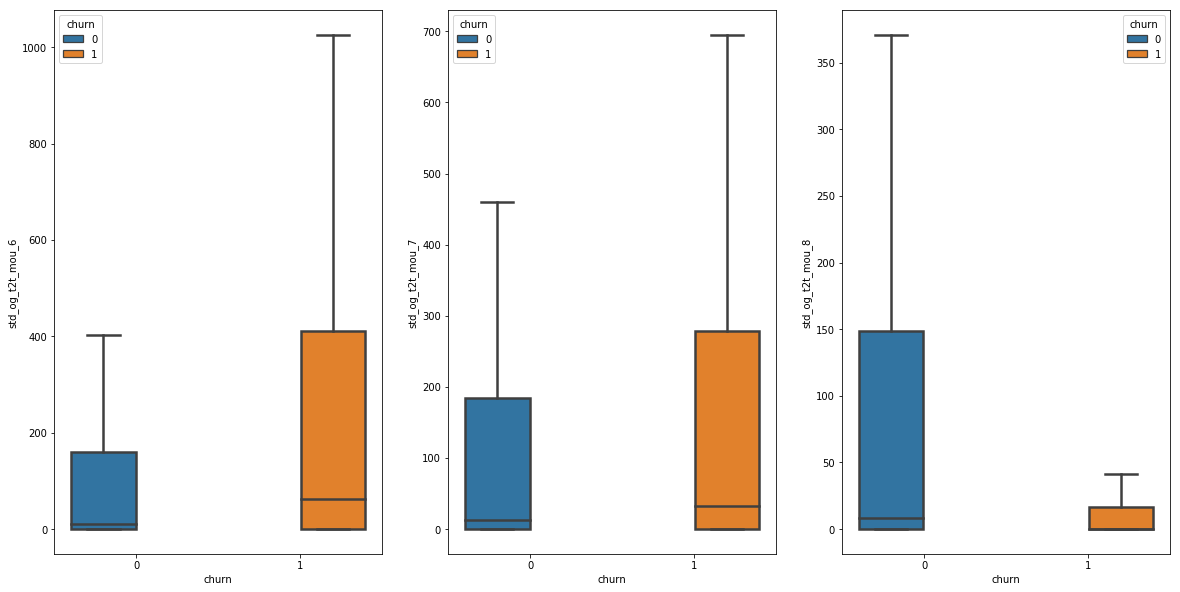

In [25]:
feature = "std_og_t2t_mou"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'roam_og_mou_6', 7: 'roam_og_mou_7', 8: 'roam_og_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,54.650613,51.683413,46.473051,39086.602924,27485.216801,30775.587262
Churned,26.926214,19.232161,19.104592,11626.929370,7806.839975,9381.284875


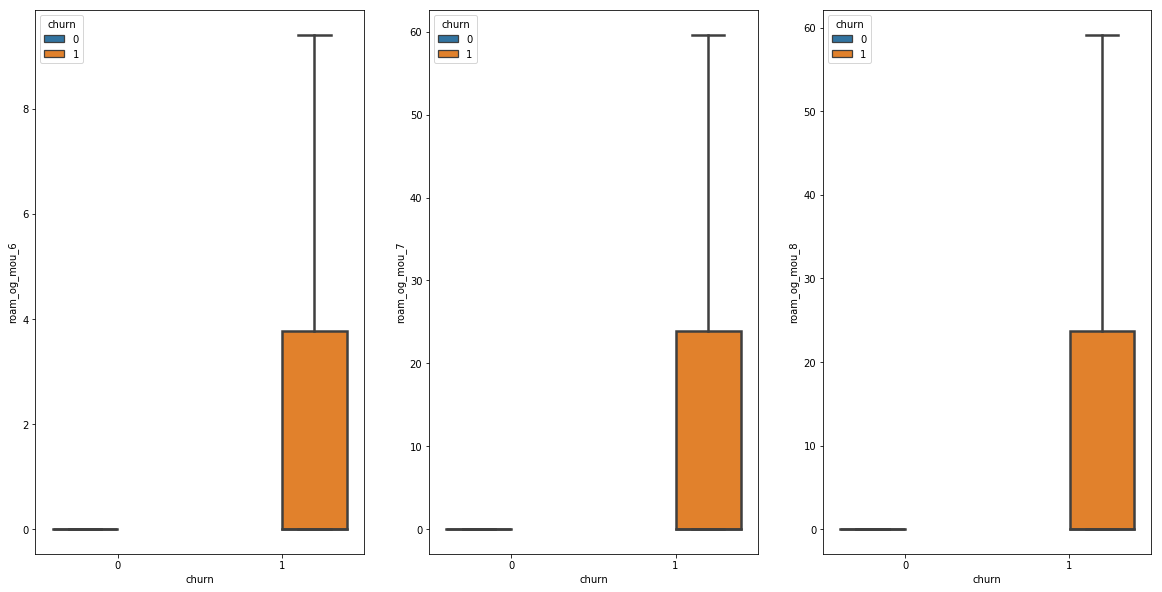

In [26]:
feature = "roam_og_mou"

# assert(feature + "_6" in columns_to_explore)
# assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
features_explored.update([feature])
features_to_explore.remove(feature)
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'total_og_mou_6', 7: 'total_og_mou_7', 8: 'total_og_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,867.961342,677.868909,225.083741,727093.347630,619308.242928,222475.153337
Churned,669.554896,712.080684,661.480046,405172.492981,455058.872408,477590.339770


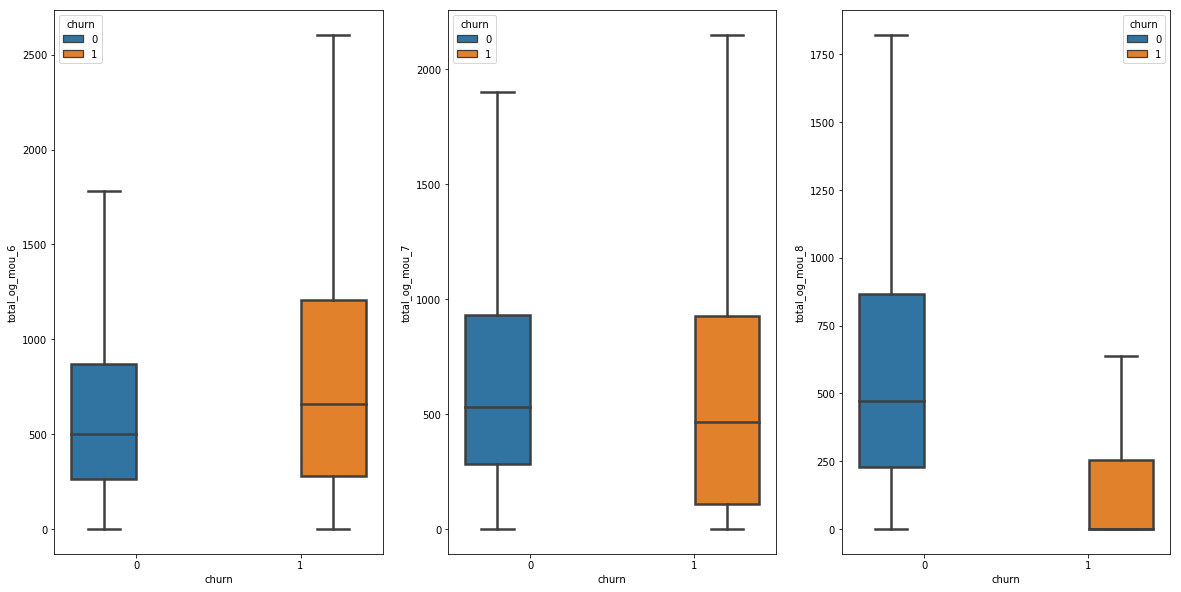

In [27]:
feature = "total_og_mou"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'std_ic_t2t_mou_6', 7: 'std_ic_t2t_mou_7', 8: 'std_ic_t2t_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,22.326880,16.808847,4.903004,10187.558393,7272.047345,570.121010
Churned,15.652688,16.901750,16.011338,5840.488083,7163.495973,5678.193471


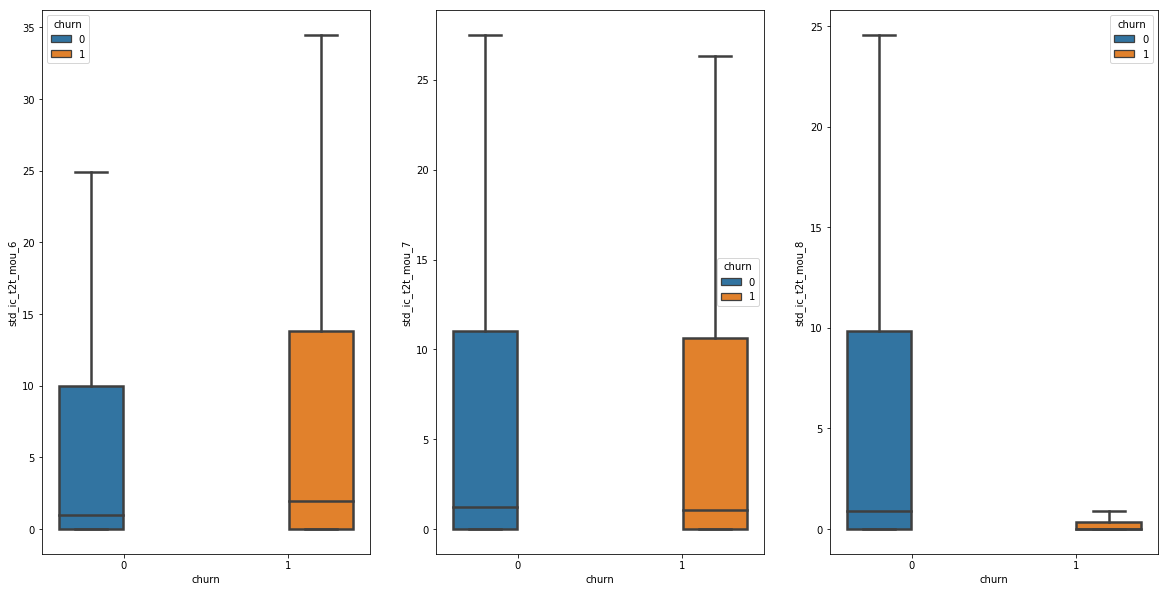

In [28]:
feature = "std_ic_t2t_mou"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'loc_og_t2m_mou_6', 7: 'loc_og_t2m_mou_7', 8: 'loc_og_t2m_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,119.381334,93.730062,34.026282,45967.396679,36334.299059,11277.728652
Churned,187.133481,189.550575,180.222822,63740.938920,59199.202684,57464.284367


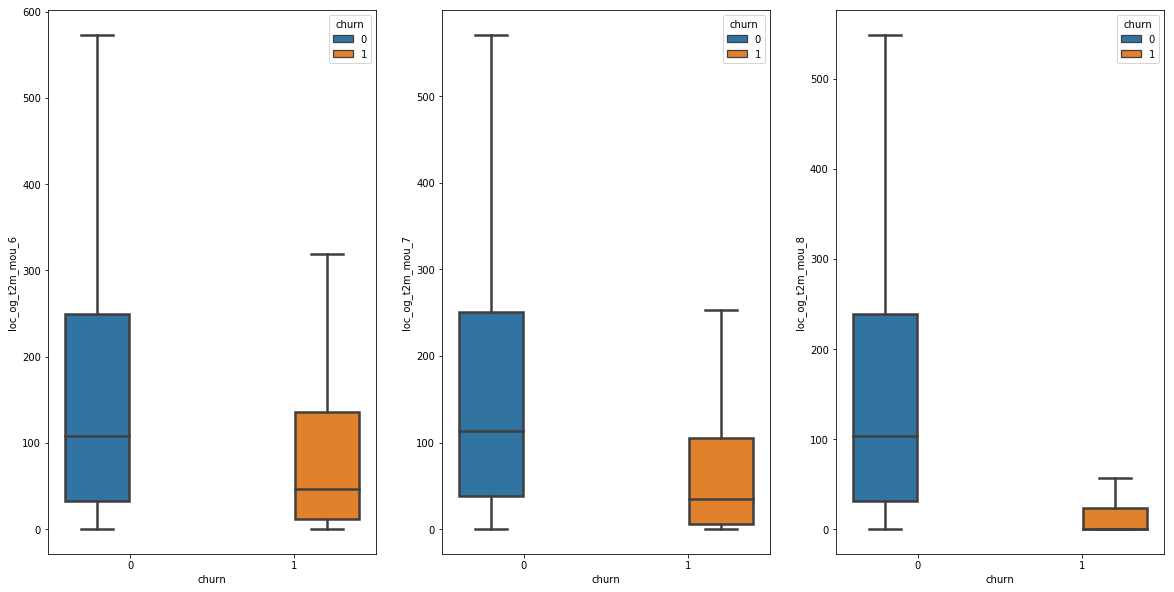

In [29]:
feature = "loc_og_t2m_mou"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'roam_ic_mou_6', 7: 'roam_ic_mou_7', 8: 'roam_ic_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,30.493803,30.458041,28.062156,19436.393968,19473.581162,15232.027953
Churned,16.175652,11.920434,11.856034,5002.449377,4502.185717,4620.940286


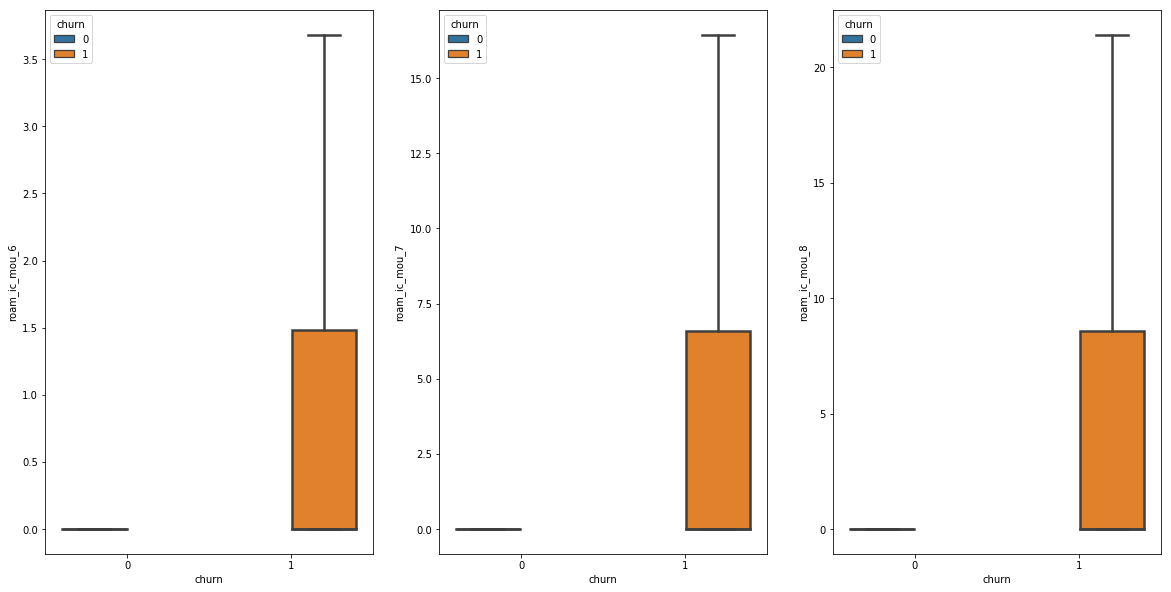

In [30]:
feature = "roam_ic_mou"
features_explored.update([feature])
# assert(feature + "_6" in columns_to_explore)
# assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
features_to_explore.remove(feature)
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'last_day_rch_amt_6', 7: 'last_day_rch_amt_7', 8: 'last_day_rch_amt_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,101.247204,78.893174,34.460085,27793.320425,22538.590050,15281.411311
Churned,104.791925,107.783281,101.440514,19681.512636,19604.186682,21263.841028


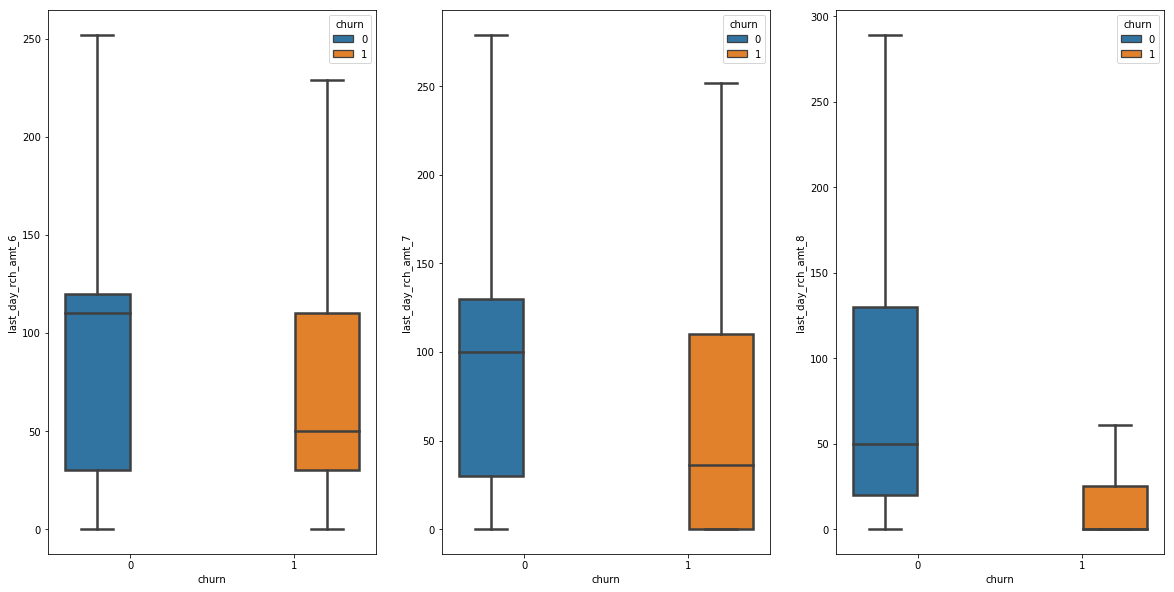

In [31]:
feature = "last_day_rch_amt"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'loc_ic_t2m_mou_6', 7: 'loc_ic_t2m_mou_7', 8: 'loc_ic_t2m_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,112.780505,88.753428,31.722653,44175.402141,30810.644729,7026.348187
Churned,164.042972,167.627918,165.157509,49542.209348,49253.918985,49352.328131


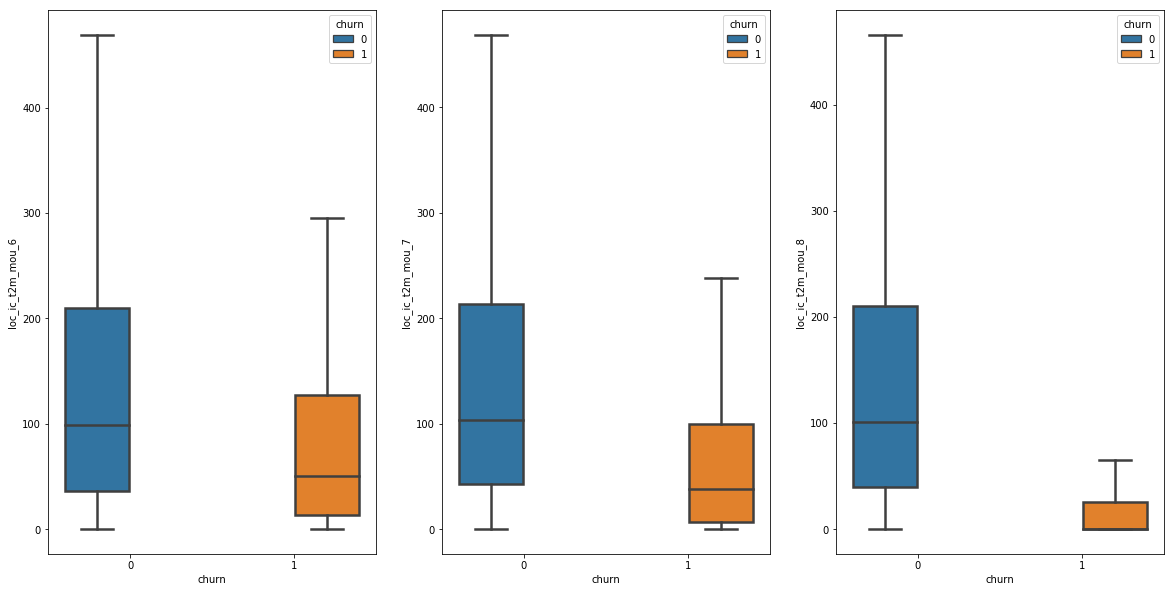

In [32]:
feature = "loc_ic_t2m_mou"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

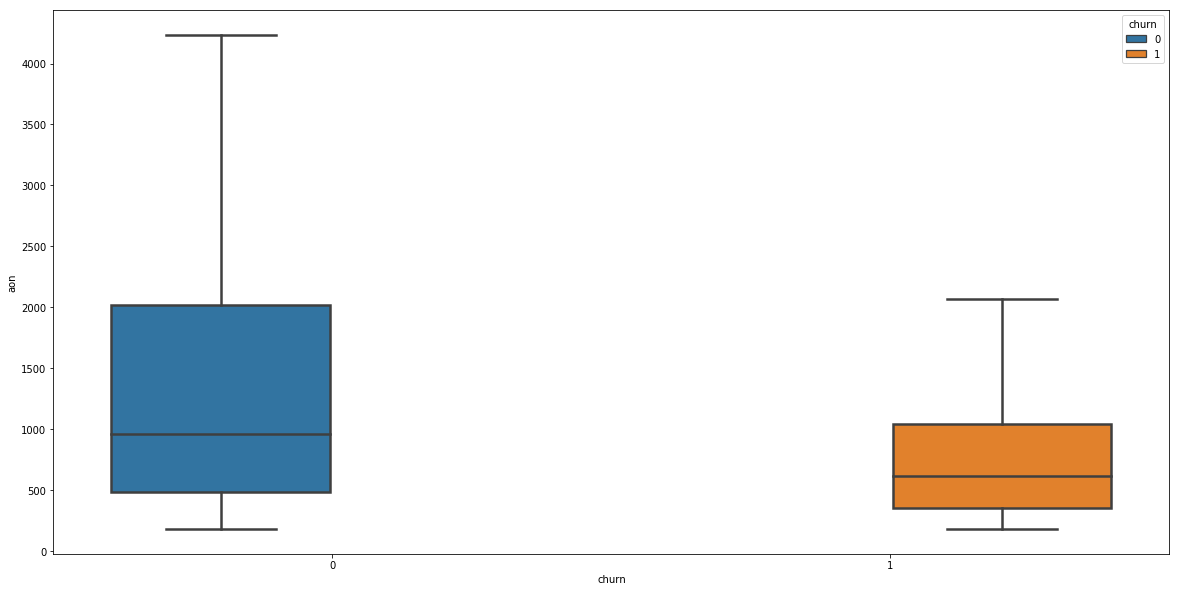

In [33]:
feature = "aon"
sns.boxplot(data=telecom_data, y=feature, x="churn", hue="churn", linewidth=2.5, showfliers=False)
features_explored.update([feature])
features_to_explore.remove(feature)

Churn Stats:
{6: 'arpu_6', 7: 'arpu_7', 8: 'arpu_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,678.71697,550.511946,243.063343,304475.364453,267538.480258,143522.421045
Churned,578.63736,592.788162,562.453248,184889.908074,209092.190859,242854.456429


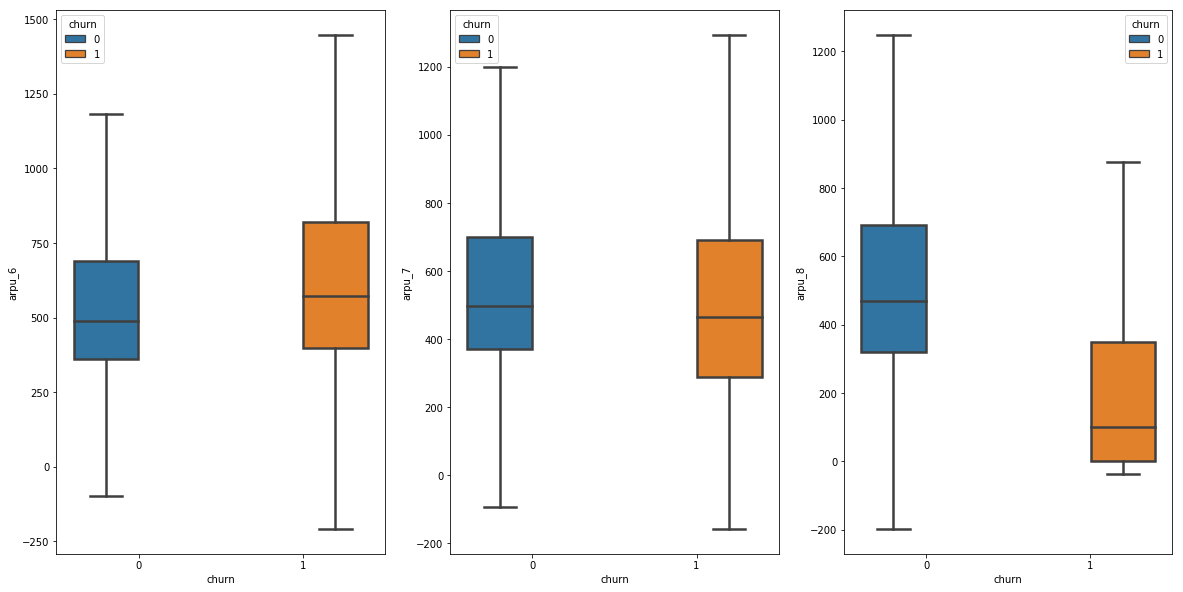

In [34]:
feature = "arpu"
features_explored.update([feature])
features_to_explore.remove(feature)
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'total_ic_mou_6', 7: 'total_ic_mou_7', 8: 'total_ic_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,241.954404,193.341076,68.807042,130203.041693,101240.939172,23854.907419
Churned,313.712052,326.369333,316.858595,130018.118999,138467.404266,134555.971371


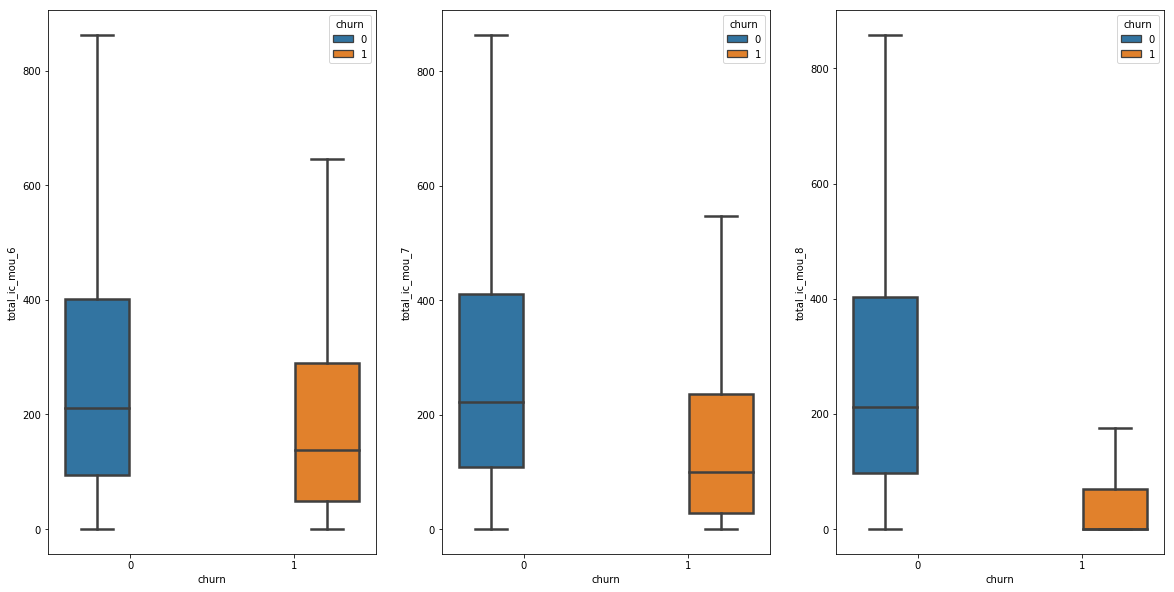

In [35]:
feature = "total_ic_mou"
features_explored.update([feature])
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
features_to_explore.remove(feature)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'max_rech_amt_6', 7: 'max_rech_amt_7', 8: 'max_rech_amt_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,166.566911,156.599691,84.193598,41564.391451,48643.081975,28996.250314
Churned,171.872456,177.463746,170.309942,29475.873472,31439.520460,29228.374151


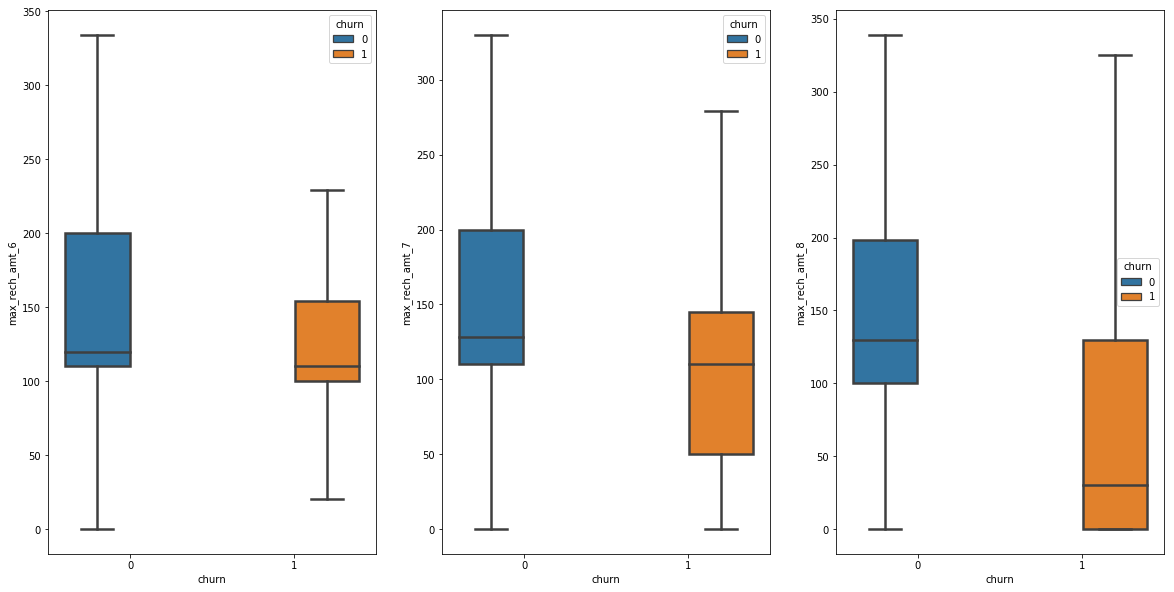

In [36]:
feature = "max_rech_amt"
features_explored.update([feature])
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
features_to_explore.remove(feature)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

/Users/helpshift/uppgdipai/.env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/helpshift/uppgdipai/.env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


0, Churn percent 0.16
1, Churn percent 0.10723860589812333
2, Churn percent 0.10084033613445378
3, Churn percent 0.0994052676295667
4, Churn percent 0.12796208530805686
5, Churn percent 0.09991532599491956
6, Churn percent 0.09090909090909091
7, Churn percent 0.09317803660565724
8, Churn percent 0.07436096049573973
9, Churn percent 0.07170099160945843
10, Churn percent 0.07274119448698316
11, Churn percent 0.09083665338645418
12, Churn percent 0.06973058637083994
13, Churn percent 0.05419847328244275
14, Churn percent 0.058695652173913045
15, Churn percent 0.061142397425583264
16, Churn percent 0.07492354740061162
17, Churn percent 0.06775510204081632
18, Churn percent 0.07586206896551724
19, Churn percent 0.08928571428571429
20, Churn percent 0.07927786499215071
21, Churn percent 0.07963875205254516
22, Churn percent 0.10628019323671498
23, Churn percent 0.09400998336106489
24, Churn percent 0.043478260869565216


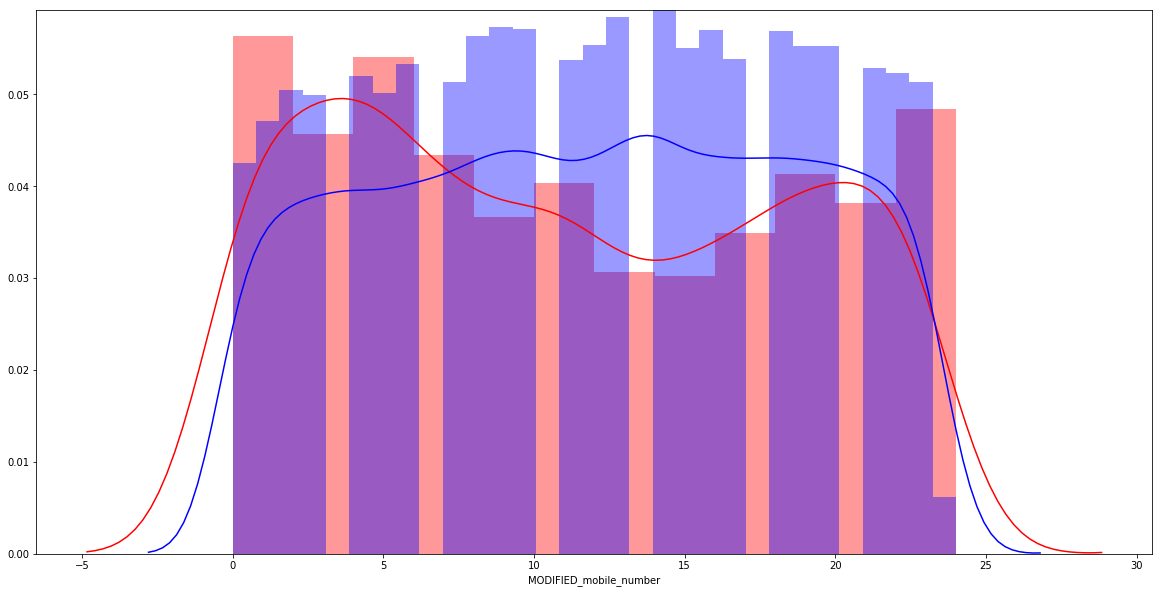

In [37]:
feature = "mobile_number"
telecom_data["MODIFIED_mobile_number"] = telecom_data["mobile_number"].apply(lambda x: int(str(x)[3:5]))
sns.distplot(telecom_data[telecom_data["churn"] == 1]["MODIFIED_mobile_number"], color="red")
sns.distplot(telecom_data[telecom_data["churn"] == 0]["MODIFIED_mobile_number"], color="blue")


for mmn in set(telecom_data["MODIFIED_mobile_number"]):
    temp_df = telecom_data[telecom_data["MODIFIED_mobile_number"] == mmn]
    print("{}, Churn percent {}".format(mmn, temp_df[temp_df["churn"] == 1].shape[0] / temp_df.shape[0]))
    

features_explored.update([feature])
features_to_explore.remove(feature)
FEATURES.append("MODIFIED_mobile_number")

Churn Stats:
{6: 'MODIFIED_day_of_month_date_of_last_rech_6', 7: 'MODIFIED_day_of_month_date_of_last_rech_7', 8: 'MODIFIED_day_of_month_date_of_last_rech_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,26.870806,25.143078,20.833783,23.187392,51.354135,95.333858
Churned,26.754614,27.619338,26.901123,19.154869,18.573076,30.968849


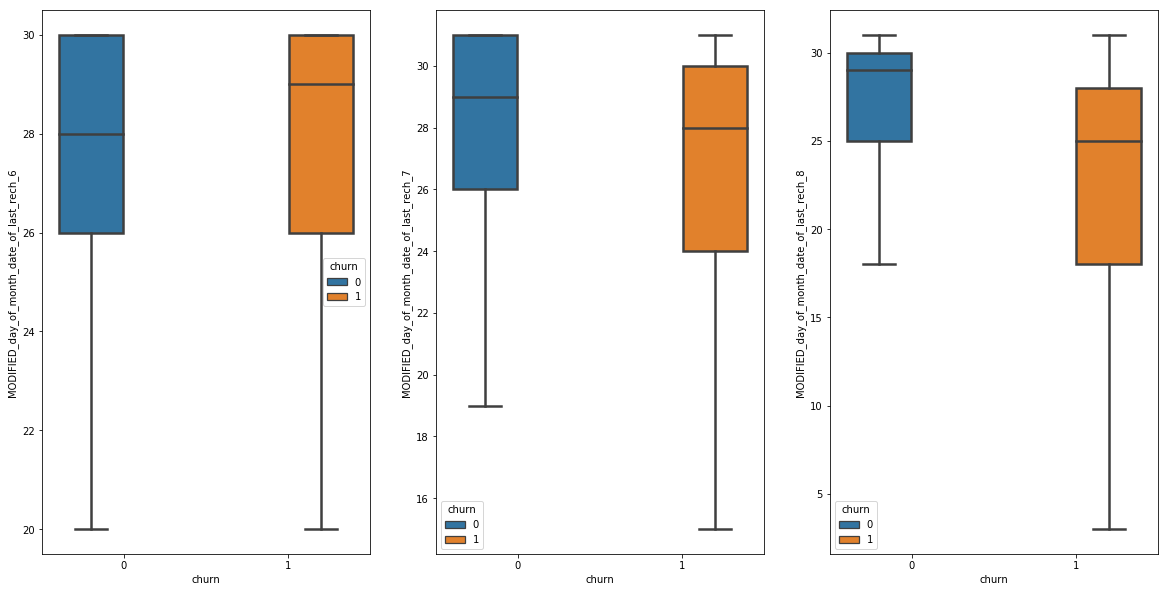

In [38]:
feature = "MODIFIED_day_of_month_date_of_last_rech"
features_explored.update([feature])
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
features_to_explore.remove(feature)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

Churn Stats:
{6: 'std_og_mou_6', 7: 'std_og_mou_7', 8: 'std_og_mou_8'}


,mean_6,mean_7,mean_8,var_6,var_7,var_8
Non Churned,666.901404,523.258758,168.787532,668862.587632,547975.203814,176326.675218
Churned,369.138814,405.120662,371.033185,331747.893406,391756.874638,395435.730360


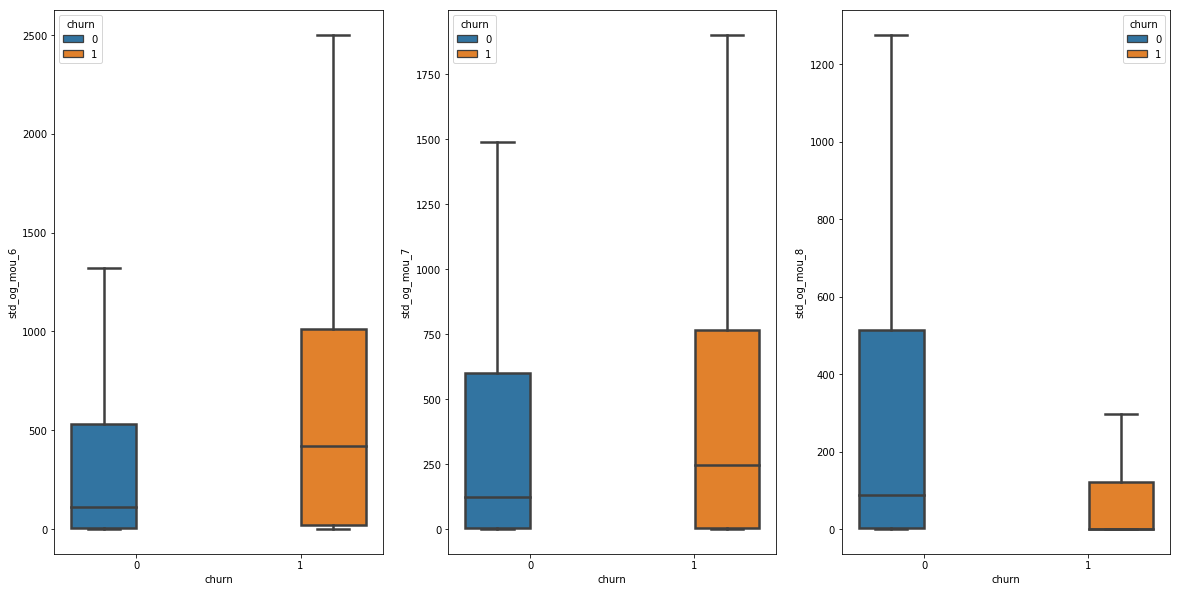

In [39]:
feature = "std_og_mou"
features_explored.update([feature])
assert(feature + "_6" in columns_to_explore)
assert(feature + "_7" in columns_to_explore)
assert(feature + "_8" in columns_to_explore)
features_to_explore.remove(feature)
## Local incoming mobile<->mobile steady in good phase suddenly drops in action phase
telecom_data[feature + "_good_phase"] = (telecom_data[feature + "_6"] +
                                             telecom_data[feature + "_7"]) / 2.0
telecom_data[feature + "_action_phase"] = telecom_data[feature + "_8"]
FEATURES.append(feature + "_good_phase")
FEATURES.append(feature + "_action_phase")
analyze_feature(feature)

In [40]:
## VIF / LR treatment

def test_model(df, cols_to_drop = None):
    cols_to_drop = cols_to_drop or []
    X = df.drop(cols_to_drop + ["churn"], axis=1)
    ## Normalize X
    X = (X - X.mean()) / (X.max() - X.min())
    Y = df["churn"]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, test_size=0.3, random_state=42)
    lr = LogisticRegression()
    lr.fit(x_train, y_train)
    print("Scoring on TEST {}, TRAIN {}".format(lr.score(x_test,y_test), lr.score(x_train,y_train)))
    x_train = sm.add_constant(x_train)
    stat_model = sm.OLS(y_train, x_train).fit()
    print(stat_model.summary())
    # calculate VIF
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    for i, var in enumerate(X.columns):
        rsq = sm.OLS(X[var], X.drop([var], axis=1)).fit().rsquared
        vif = round( 1 / (1 - rsq + 0.00000000001), 2)
        vif_df.loc[i] = [var, vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)



In [93]:
td_Model_input = telecom_data[telecom_data["churn"] == 1][FEATURES + ["churn"]]
td_Model_input = pd.concat([td_Model_input, telecom_data[telecom_data["churn"] == 0][FEATURES + ["churn"]].sample(td_Model_input.shape[0])])

columns_rename_map = {ft: ft.replace("_good_phase", "_GP")
                            .replace("_action_phase", "_AP")
                      for ft in FEATURES}
columns_rename_map["churn"] = "churn"
td_Model_input = td_Model_input.rename(index=str, columns=columns_rename_map)

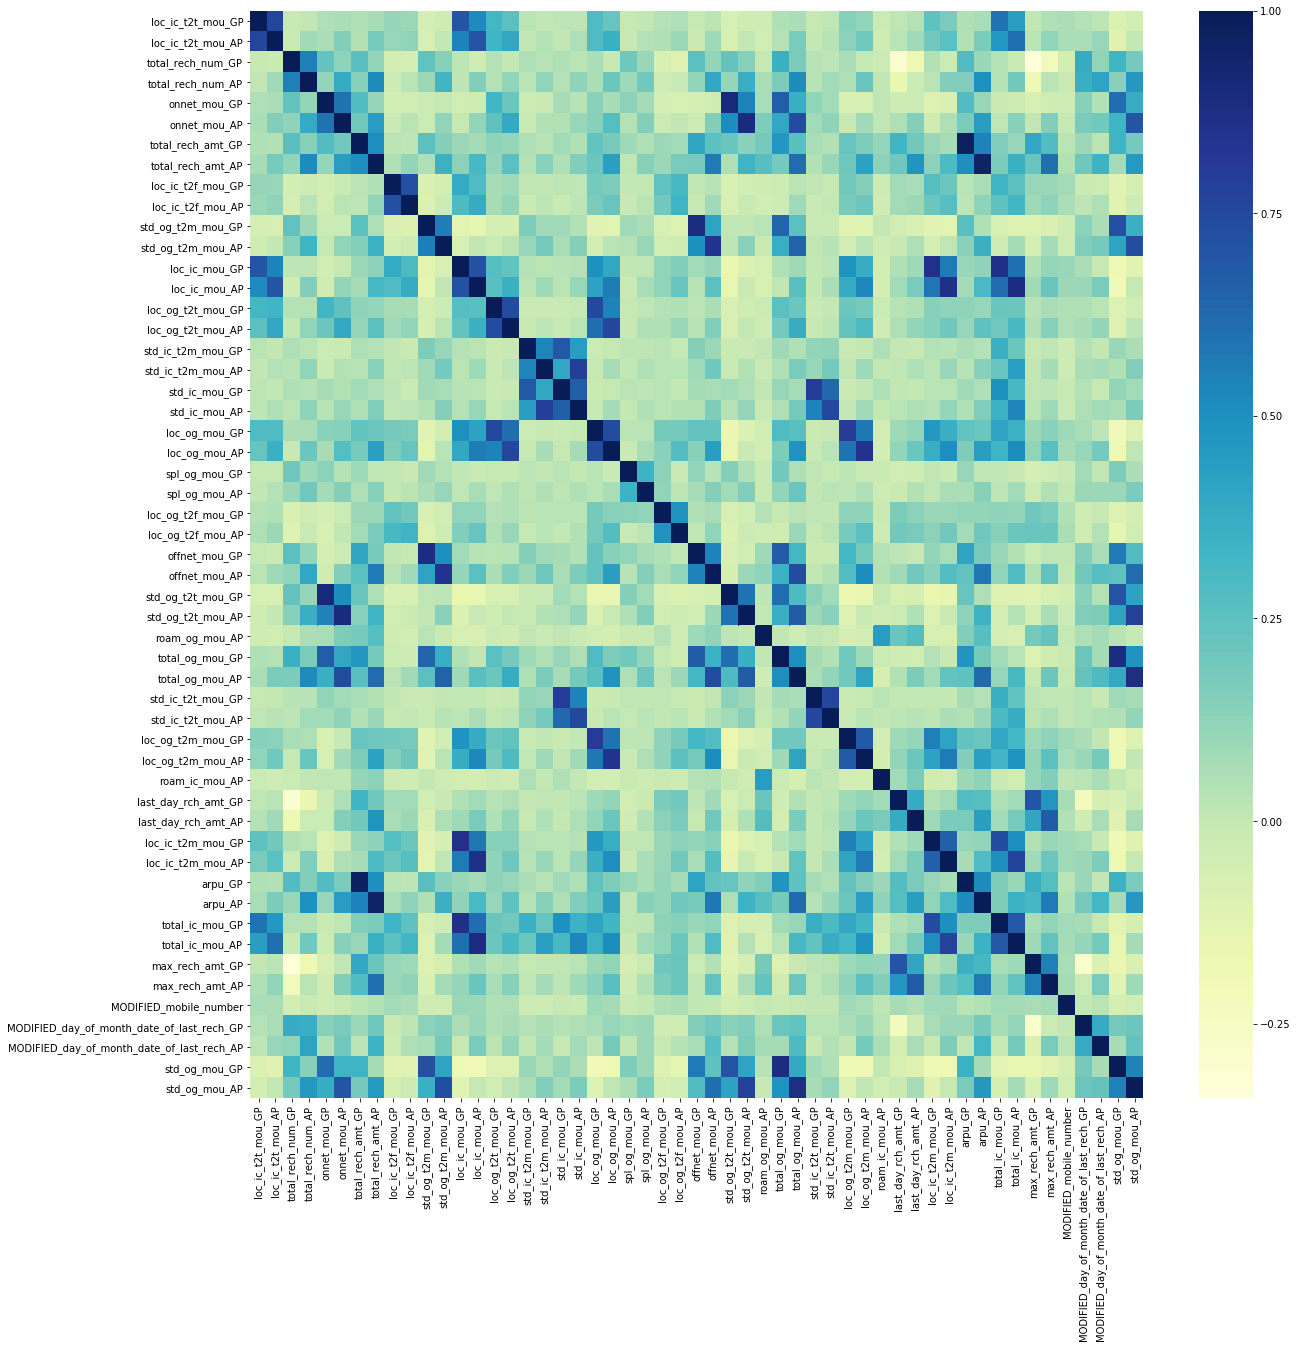

In [47]:
plt.figure(figsize=(20, 20))
sns.heatmap(td_Model_input.drop(["churn"], axis=1).corr(), cmap="YlGnBu")

In [48]:
test_model(td_Model_input)

Scoring on TEST 0.8258354755784062, TRAIN 0.8151515151515152
                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     49.87
Date:                Sat, 09 Jun 2018   Prob (F-statistic):               0.00
Time:                        17:59:35   Log-Likelihood:                -1630.1
No. Observations:                3630   AIC:                             3368.
Df Residuals:                    3576   BIC:                             3703.
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

,Var,Vif
20,loc_og_mou_GP,5.088675e+09
12,loc_ic_mou_GP,3.907504e+09
21,loc_og_mou_AP,3.118423e+09
13,loc_ic_mou_AP,2.391374e+09
35,loc_og_t2m_mou_GP,2.335427e+09
14,loc_og_t2t_mou_GP,1.900172e+09
40,loc_ic_t2m_mou_GP,1.887421e+09
36,loc_og_t2m_mou_AP,1.412784e+09
41,loc_ic_t2m_mou_AP,1.179686e+09
0,loc_ic_t2t_mou_GP,1.057286e+09


In [94]:
test_model(td_Model_input, cols_to_drop=["total_og_mou_GP", "loc_og_mou_AP", "loc_og_mou_GP",
                                         "std_ic_t2m_mou_GP", "loc_ic_mou_GP", "loc_ic_mou_AP",
                                         "std_og_mou_AP", "std_og_mou_GP", "offnet_mou_AP", "total_og_mou_AP",
                                         "std_og_t2m_mou_GP", "spl_og_mou_GP", "std_ic_mou_AP", "loc_ic_t2m_mou_AP",
                                         "onnet_mou_AP", "onnet_mou_GP", "loc_ic_t2t_mou_AP", "total_ic_mou_GP",
                                         "loc_ic_t2f_mou_GP", "std_ic_t2t_mou_AP", "total_rech_amt_GP", "total_rech_amt_AP",
                                         "loc_og_t2f_mou_GP", "std_ic_mou_GP", "max_rech_amt_AP",
                                         "std_ic_t2m_mou_AP", "last_day_rch_amt_GP", "loc_ic_t2t_mou_GP",
                                         "MODIFIED_mobile_number", "loc_ic_t2m_mou_GP", "MODIFIED_day_of_month_date_of_last_rech_GP",
                                         "loc_og_t2t_mou_GP", "loc_ic_t2f_mou_AP", "loc_og_t2m_mou_GP", "max_rech_amt_GP"])




Scoring on TEST 0.8200514138817481, TRAIN 0.8258953168044078
                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     121.1
Date:                Sat, 09 Jun 2018   Prob (F-statistic):               0.00
Time:                        18:29:33   Log-Likelihood:                -1777.6
No. Observations:                3630   AIC:                             3593.
Df Residuals:                    3611   BIC:                             3711.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

,Var,Vif
15,arpu_AP,3.77
1,total_rech_num_AP,2.82
14,arpu_GP,2.25
8,std_og_t2t_mou_AP,2.20
6,offnet_mou_GP,2.14
7,std_og_t2t_mou_GP,2.03
0,total_rech_num_GP,1.99
2,std_og_t2m_mou_AP,1.90
11,loc_og_t2m_mou_AP,1.81
16,total_ic_mou_AP,1.58


In [92]:
all_data = telecom_data[FEATURES + ["churn"]]
all_data = all_data.rename(index=str, columns=columns_rename_map)

test_model(all_data, cols_to_drop=["total_og_mou_GP", "loc_og_mou_AP", "loc_og_mou_GP",
                                         "std_ic_t2m_mou_GP", "loc_ic_mou_GP", "loc_ic_mou_AP",
                                         "std_og_mou_AP", "std_og_mou_GP", "offnet_mou_AP", "total_og_mou_AP",
                                         "std_og_t2m_mou_GP", "spl_og_mou_GP", "std_ic_mou_AP", "loc_ic_t2m_mou_AP",
                                         "onnet_mou_AP", "onnet_mou_GP", "loc_ic_t2t_mou_AP", "total_ic_mou_GP",
                                         "loc_ic_t2f_mou_GP", "std_ic_t2t_mou_AP", "total_rech_amt_GP", "total_rech_amt_AP",
                                         "loc_og_t2f_mou_GP", "std_ic_mou_GP", "max_rech_amt_AP",
                                         "std_ic_t2m_mou_AP", "last_day_rch_amt_GP", "loc_ic_t2t_mou_GP",
                                         "MODIFIED_mobile_number", "loc_ic_t2m_mou_GP", "MODIFIED_day_of_month_date_of_last_rech_GP",
                                         "loc_og_t2t_mou_GP", "loc_ic_t2f_mou_AP", "loc_og_t2m_mou_GP", "max_rech_amt_GP"])


Scoring on TEST 0.9217014660151044, TRAIN 0.9215499595372971
                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     262.6
Date:                Sat, 09 Jun 2018   Prob (F-statistic):               0.00
Time:                        18:28:52   Log-Likelihood:                -1030.7
No. Observations:               21007   AIC:                             2099.
Df Residuals:                   20988   BIC:                             2250.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

,Var,Vif
15,arpu_AP,4.51
14,arpu_GP,3.94
1,total_rech_num_AP,3.46
8,std_og_t2t_mou_AP,2.89
0,total_rech_num_GP,2.87
7,std_og_t2t_mou_GP,2.84
6,offnet_mou_GP,2.83
2,std_og_t2m_mou_AP,2.43
11,loc_og_t2m_mou_AP,1.83
9,roam_og_mou_AP,1.57
